
MMDetection tutorial을 활용하여 베이스라인을 만들었습니다.

coco format으로 변환하는 부분은 이여름님께서 공유해주신 [코드](https://dacon.io/competitions/official/235855/codeshare/3729)를 참고했고

데이터 정제 과정과 추론 부분은 데이콘에서 제공해 주신 [베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)을 참고했습니다.


**참고 링크** <p>
- [이여름님의 코드](https://dacon.io/competitions/official/235855/codeshare/3729)
- [데이콘 베이스라인](https://dacon.io/competitions/official/235855/codeshare/3725)
- [colab version tutorial](https://github.com/open-mmlab/mmdetection/blob/master/demo/MMDet_Tutorial.ipynb)
- [kaggle notebook](https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21)


**MMDetection 관련 링크**
- [mmdetection github](https://github.com/open-mmlab/mmdetection)
- [mmdetection docs](https://mmdetection.readthedocs.io/)
- [model_zoo](https://mmdetection.readthedocs.io/en/latest/model_zoo.html#baselines)

*❗❗* 코드는 모든 학습 데이터를 사용할 수 있도록 해놓았지만 출력은 일부 데이터만 사용한 결과물이며 로컬 환경과 코랩 환경을 오가며 진행했습니다.

## Prepare data

conda install pytorch==1.10.0 torchvision==0.11.0 torchaudio==0.10.0 cudatoolkit=11.3 -c pytorch -c conda-forge

pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu113/torch1.10.0/index.html

git clone https://github.com/open-mmlab/mmdetection.git

pip install -r requirements/build.txt

pip install pycocotools-windows

pip install -v -e .





In [1]:
# basic setup
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
import base64
import time
import math
import datetime
import os
import zipfile
import random
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from glob import glob

from collections import defaultdict

base_dir = "/home/ubuntu/mmdet512/input"


In [2]:
pwd

'/home/ubuntu/mmdet512'

In [3]:
os.makedirs('./input', exist_ok=True)
os.makedirs('./output', exist_ok=True)
%cd input

/home/ubuntu/mmdet512/input


In [3]:
cd /home/ubuntu/mmdet512/input

/home/ubuntu/mmdet512/input


In [4]:
df = pd.read_csv('./train.csv', index_col = 0)
df = df[df['class_id'] != 14]
df['class_id'] = df['class_id'] + 1
df = df[['image_id', 'class_id', 'x_min', 'y_min', 'x_max', 'y_max']]
df

,image_id,class_id,x_min,y_min,x_max,y_max
6,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.092308,301.369863,406.892308,401.315068
7,9a5094b2563a1ef3ff50dc5c7ff71345,11,440.369231,378.958904,461.538462,436.602740
8,9a5094b2563a1ef3ff50dc5c7ff71345,12,440.369231,378.958904,461.538462,436.602740
9,9a5094b2563a1ef3ff50dc5c7ff71345,4,170.338462,301.369863,407.876923,394.301370
10,9a5094b2563a1ef3ff50dc5c7ff71345,4,169.600000,287.780822,410.092308,386.410959
...,...,...,...,...,...,...
67774,52951d7de2485aba8ed62629eee4d254,10,67.333333,256.355556,85.111111,268.088889
67775,52951d7de2485aba8ed62629eee4d254,4,163.111111,279.288889,358.666667,336.355556
67848,1224f07d895107573588225f692e94f9,1,250.729412,161.922261,320.250980,223.434629
67849,1224f07d895107573588225f692e94f9,1,262.525490,155.590106,319.247059,221.399293


In [5]:
def convert_to_coco(name_list, df, save_path): # 변경

  res = defaultdict(list)
    
  categories = {
      'Aortic enlargement': 1,
      'Atelectasis': 2,
      'Calcification': 3,
      'Cardiomegaly': 4,
      'Consolidation': 5,
      'ILD': 6,
      'Infiltration': 7,
      'Lung Opacity': 8,
      'Nodule/Mass': 9,
      'Other lesion': 10,
      'Pleural effusion': 11,
      'Pleural thickening': 12,
      'Pneumothorax': 13,
      'Pulmonary fibrosis': 14
  }
    
  df = df[df['image_id'].isin(name_list)]
  names = df['image_id'].unique()
  n_id = 0

  for pic_name in tqdm(names):

    df_temp = df[df['image_id'] == pic_name]
    tmp = df_temp.values

    res['images'].append({
        'id': pic_name,
        'width': 512,
        'height': 512,
        'file_name': pic_name+".png"
    })
      
    for shape in tmp:
        x1, y1, x2, y2 = shape[2], shape[3], shape[4], shape[5]
        
        w, h = x2 - x1, y2 - y1
        
        res['annotations'].append({
            'id': n_id,
            'image_id': pic_name,
            'category_id': shape[1],
            'area': w * h,
            'bbox': [x1, y1, w, h],
            'iscrowd': 0,
        })
        n_id += 1
    
  for name, id in categories.items():
      res['categories'].append({
          'id': id,
          'name': name,
      })
  # return res
  with open(save_path, 'w') as f:
      json.dump(res, f)

In [6]:
random.seed(10)

# train_files = glob(os.path.join(base_dir, 'train/*.png'))
# train_files = os.listdir('./input/train')
# train_files = list(map(del_extension, train_files))
train_files = df['image_id'].unique()

random.shuffle(train_files)

# 8:2로 학습/검증 데이터 분리
split_num = int(len(train_files)*0.2)
print("split_num :", split_num)

train_file = train_files[split_num:]
valid_file = train_files[:split_num]

len(train_file), len(valid_file),len(train_files)

split_num : 878


(3516, 878, 4394)

In [7]:
convert_to_coco(train_file, df, os.path.join(base_dir, 'train_annotations.json'))

  0%|          | 0/3516 [00:00<?, ?it/s]

In [8]:
convert_to_coco(valid_file, df, os.path.join(base_dir, 'valid_annotations.json'))

  0%|          | 0/878 [00:00<?, ?it/s]

## Environment setting

In [9]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Tue_Mar__8_18:18:20_PST_2022
Cuda compilation tools, release 11.6, V11.6.124
Build cuda_11.6.r11.6/compiler.31057947_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [10]:
!pip show torch

Name: torch
Version: 1.10.0
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /home/ubuntu/anaconda3/envs/pytorch112_p38/lib/python3.8/site-packages
Requires: typing_extensions
Required-by: timm, torchaudio, torchvision


런타임 다시 시작하고 진행합니다.

In [11]:
%cd ../

/home/ubuntu/mmdet512


In [12]:
!git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [12]:
%cd ./mmdetection

/home/ubuntu/mmdet512/mmdetection


=========

In [13]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.10.0 True
2.25.2
11.3
GCC 9.3


In [14]:
pwd

'/home/ubuntu/mmdet512/mmdetection'

In [15]:
# cascade_rcnn

!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth \
      -O checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth

mkdir: cannot create directory ‘checkpoints’: File exists
--2022-10-21 00:06:48--  https://download.openmmlab.com/mmdetection/v2.0/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.43
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.43|:443... connected.
HTTP request sent, awaiting response... 200 OK

    The file is already fully retrieved; nothing to do.



In [16]:
config = "/home/ubuntu/mmdet512/mmdetection/configs/cascade_rcnn/cascade_rcnn_r50_fpn_1x_coco.py"

checkpoint = '/home/ubuntu/mmdet512/mmdetection/checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth'

## Train a detector on customized dataset

To train a new detector, there are usually three things to do:
1. Support a new dataset
2. Modify the config
3. Train a new detector



In [17]:
import mmcv
import matplotlib.pyplot as plt
import copy
import os.path as osp
import numpy as np

### Modify the config

In the next step, we need to modify the config for the training.
To accelerate the process, we finetune a detector using a pre-trained detector.

In [18]:
from mmcv import Config
cfg = Config.fromfile(config)

Given a config that trains a Faster R-CNN on COCO dataset, we need to modify some values to use it for training Faster R-CNN on KITTI dataset.

In [19]:
from mmdet.apis import set_random_seed

base_path = '/home/ubuntu/mmdet512/input' 
%cd '/home/ubuntu/mmdet512/input'

/home/ubuntu/mmdet512/input


In [20]:
save_dir = os.path.join(base_path, "work_dir")
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_dir

'/home/ubuntu/mmdet512/input/work_dir'

In [21]:
EPOCHS = 30

# Set up working dir to save files and logs.
cfg.work_dir = save_dir+'/casa/2'


val_anno = "valid_annotations.json"  
test_anno = "valid_annotations.json" # 출력은 "valid_partial_annotations.json"
train_anno = "train_annotations.json" # 출력은 "train_partial_annotations.json"

# 이미지 폴더 설정
train_img = "train" # 출력은 "train_100000"
val_img = 'train'
test_img =  "test"

# Modify dataset type and path
cfg.dataset_type = 'CocoDataset'
cfg.data_root = base_path

#train
cfg.data.train.type = 'CocoDataset'
cfg.data.train.data_root = base_path
cfg.data.train.ann_file = train_anno
cfg.data.train.img_prefix = train_img

#valid
cfg.data.val.type = 'CocoDataset'
cfg.data.val.data_root = base_path
cfg.data.val.ann_file = val_anno
cfg.data.val.img_prefix = val_img

# test
cfg.data.test.type = 'CocoDataset'
cfg.data.test.data_root = base_path
cfg.data.test.ann_file = test_anno
cfg.data.test.img_prefix = test_img

cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu = 2

classes = (
    'Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis'
    )

cfg.data.train.classes = classes
cfg.data.val.classes = classes
cfg.data.test.classes = classes


# modify num classes of the model in box head
# 직접 가서 바꿈 !!!!!???
cfg.model.roi_head.bbox_head[0]['num_classes'] = 14
cfg.model.roi_head.bbox_head[1]['num_classes'] = 14
cfg.model.roi_head.bbox_head[2]['num_classes'] = 14
# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch

cfg.load_from = checkpoint

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None

# 에폭 수 조절
cfg.runner = dict(type='EpochBasedRunner', max_epochs=EPOCHS)

cfg.log_config.interval = 2

# Change the evaluation metric since we use customized dataset.
#COCO dataset은 mmdetection에서 mAP metric을 지원하지 않아 VOC로 테스트
cfg.evaluation.metric = 'bbox'
# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 4
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

cfg.device='cuda'


# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='CascadeRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_

### Train a new detector

Finally, lets initialize the dataset and detector, then train a new detector!

In [22]:
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector


# Build dataset
datasets = [build_dataset(cfg.data.train)]
print(datasets)

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
[
CocoDataset Train dataset with number of images 3516, and instance counts: 
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| category               | count | category                | count | category          | count | category                | count | category          | count |
+------------------------+-------+-------------------------+-------+-------------------+-------+-------------------------+-------+-------------------+-------+
| 0 [Aortic enlargement] | 5793  | 1 [Atelectasis]         | 209   | 2 [Calcification] | 808   | 3 [Cardiomegaly]        | 4357  | 4 [Consolidation] | 441   |
| 5 [ILD]                | 806   | 6 [Infiltration]        | 1042  | 7 [Lung Opacity]  | 1980  | 8 [Nodule/Mass]         | 2058  | 9 [Other lesion]  | 1742  |
| 10 [Pleural effusion]  | 1921  | 11 [Pleur

In [23]:
# Build the detector
model = build_detector(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

2022-10-21 00:12:56,265 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.
2022-10-21 00:12:56,299 - mmdet - INFO - load checkpoint from local path: /home/ubuntu/mmdet512/mmdetection/checkpoints/cascade_rcnn_r50_fpn_1x_coco_20200316-3dc56deb.pth


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2022-10-21 00:12:57,468 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for roi_head.bbox_head.1.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.1.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for roi_head.bbox_head.2.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([15, 1024]).
size mismatch for roi_head.bbox_head.2.fc_cls.bias: cop

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.8 task/s, elapsed: 37s, ETA:     0s

2022-10-21 00:36:04,430 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.02s).
Accumulating evaluation results...


2022-10-21 00:36:07,345 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.203
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.069
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.034
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.114
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.180
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.097
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.167
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.68s).


2022-10-21 00:36:11,241 - mmdet - INFO - Epoch [5][2/440]	lr: 2.500e-03, eta: 2:25:53, time: 1.871, data_time: 1.149, memory: 8638, loss_rpn_cls: 0.0524, loss_rpn_bbox: 0.0276, s0.loss_cls: 0.2635, s0.acc: 91.5894, s0.loss_bbox: 0.1677, s1.loss_cls: 0.1145, s1.acc: 92.4316, s1.loss_bbox: 0.1668, s2.loss_cls: 0.0492, s2.acc: 93.8965, s2.loss_bbox: 0.0843, loss: 0.9259
2022-10-21 00:36:12,758 - mmdet - INFO - Epoch [5][4/440]	lr: 2.500e-03, eta: 2:25:51, time: 0.758, data_time: 0.065, memory: 8638, loss_rpn_cls: 0.0420, loss_rpn_bbox: 0.0218, s0.loss_cls: 0.2117, s0.acc: 93.3960, s0.loss_bbox: 0.1276, s1.loss_cls: 0.0981, s1.acc: 93.8322, s1.loss_bbox: 0.1374, s2.loss_cls: 0.0415, s2.acc: 94.7473, s2.loss_bbox: 0.0784, loss: 0.7585
2022-10-21 00:36:14,257 - mmdet - INFO - Epoch [5][6/440]	lr: 2.500e-03, eta: 2:25:50, time: 0.750, data_time: 0.064, memory: 8638, loss_rpn_cls: 0.0477, loss_rpn_bbox: 0.0276, s0.loss_cls: 0.3157, s0.acc: 90.3687, s0.loss_bbox: 0.1870, s1.loss_cls: 0.1473, s1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.6 task/s, elapsed: 37s, ETA:     0s

2022-10-21 00:59:09,118 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.98s).
Accumulating evaluation results...


2022-10-21 00:59:11,859 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.236
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.101
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.137
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.218
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.098
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.194
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.54s).


2022-10-21 00:59:15,747 - mmdet - INFO - Epoch [9][2/440]	lr: 2.500e-04, eta: 2:03:05, time: 1.865, data_time: 1.152, memory: 8639, loss_rpn_cls: 0.0179, loss_rpn_bbox: 0.0232, s0.loss_cls: 0.2746, s0.acc: 90.1123, s0.loss_bbox: 0.1837, s1.loss_cls: 0.1415, s1.acc: 89.8331, s1.loss_bbox: 0.1966, s2.loss_cls: 0.0647, s2.acc: 90.4191, s2.loss_bbox: 0.1067, loss: 1.0089
2022-10-21 00:59:17,246 - mmdet - INFO - Epoch [9][4/440]	lr: 2.500e-04, eta: 2:03:03, time: 0.749, data_time: 0.068, memory: 8639, loss_rpn_cls: 0.0255, loss_rpn_bbox: 0.0244, s0.loss_cls: 0.2419, s0.acc: 91.7480, s0.loss_bbox: 0.1420, s1.loss_cls: 0.1204, s1.acc: 91.8021, s1.loss_bbox: 0.1541, s2.loss_cls: 0.0584, s2.acc: 92.6977, s2.loss_bbox: 0.0881, loss: 0.8548
2022-10-21 00:59:18,741 - mmdet - INFO - Epoch [9][6/440]	lr: 2.500e-04, eta: 2:03:02, time: 0.747, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0322, loss_rpn_bbox: 0.0292, s0.loss_cls: 0.2091, s0.acc: 92.7002, s0.loss_bbox: 0.1554, s1.loss_cls: 0.0993, s1

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.4 task/s, elapsed: 37s, ETA:     0s

2022-10-21 01:22:09,418 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.09s).
Accumulating evaluation results...


2022-10-21 01:22:12,309 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.248
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.227
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.111
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.58s).


2022-10-21 01:22:16,222 - mmdet - INFO - Epoch [13][2/440]	lr: 2.500e-05, eta: 1:40:34, time: 1.878, data_time: 1.159, memory: 8639, loss_rpn_cls: 0.0221, loss_rpn_bbox: 0.0195, s0.loss_cls: 0.1881, s0.acc: 93.1152, s0.loss_bbox: 0.1397, s1.loss_cls: 0.0888, s1.acc: 93.3407, s1.loss_bbox: 0.1682, s2.loss_cls: 0.0446, s2.acc: 93.6975, s2.loss_bbox: 0.1082, loss: 0.7792
2022-10-21 01:22:17,713 - mmdet - INFO - Epoch [13][4/440]	lr: 2.500e-05, eta: 1:40:32, time: 0.745, data_time: 0.066, memory: 8639, loss_rpn_cls: 0.0138, loss_rpn_bbox: 0.0171, s0.loss_cls: 0.1843, s0.acc: 93.8232, s0.loss_bbox: 0.1297, s1.loss_cls: 0.0879, s1.acc: 93.8491, s1.loss_bbox: 0.1521, s2.loss_cls: 0.0419, s2.acc: 93.4179, s2.loss_bbox: 0.0926, loss: 0.7194
2022-10-21 01:22:19,202 - mmdet - INFO - Epoch [13][6/440]	lr: 2.500e-05, eta: 1:40:31, time: 0.745, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0270, loss_rpn_bbox: 0.0205, s0.loss_cls: 0.2040, s0.acc: 92.3340, s0.loss_bbox: 0.1306, s1.loss_cls: 0.1059,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.4 task/s, elapsed: 38s, ETA:     0s

2022-10-21 01:45:08,669 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.11s).
Accumulating evaluation results...


2022-10-21 01:45:11,581 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.111
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.250
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.045
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.144
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.108
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.57s).


2022-10-21 01:45:15,498 - mmdet - INFO - Epoch [17][2/440]	lr: 2.500e-05, eta: 1:18:09, time: 1.879, data_time: 1.158, memory: 8639, loss_rpn_cls: 0.0193, loss_rpn_bbox: 0.0189, s0.loss_cls: 0.1679, s0.acc: 93.9087, s0.loss_bbox: 0.1326, s1.loss_cls: 0.0719, s1.acc: 95.1843, s1.loss_bbox: 0.1559, s2.loss_cls: 0.0349, s2.acc: 95.6298, s2.loss_bbox: 0.1029, loss: 0.7044
2022-10-21 01:45:17,026 - mmdet - INFO - Epoch [17][4/440]	lr: 2.500e-05, eta: 1:18:07, time: 0.764, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0191, loss_rpn_bbox: 0.0190, s0.loss_cls: 0.2834, s0.acc: 91.1743, s0.loss_bbox: 0.1580, s1.loss_cls: 0.1441, s1.acc: 90.9753, s1.loss_bbox: 0.1891, s2.loss_cls: 0.0743, s2.acc: 89.4511, s2.loss_bbox: 0.1114, loss: 0.9986
2022-10-21 01:45:18,521 - mmdet - INFO - Epoch [17][6/440]	lr: 2.500e-05, eta: 1:18:06, time: 0.748, data_time: 0.068, memory: 8639, loss_rpn_cls: 0.0195, loss_rpn_bbox: 0.0243, s0.loss_cls: 0.2635, s0.acc: 92.1753, s0.loss_bbox: 0.1564, s1.loss_cls: 0.1151,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.3 task/s, elapsed: 38s, ETA:     0s

2022-10-21 02:08:08,048 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.16s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.15s).
Accumulating evaluation results...


2022-10-21 02:08:10,995 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.249
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.087
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.105
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.143
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.207
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.57s).


2022-10-21 02:08:14,886 - mmdet - INFO - Epoch [21][2/440]	lr: 2.500e-05, eta: 0:55:47, time: 1.866, data_time: 1.149, memory: 8639, loss_rpn_cls: 0.0240, loss_rpn_bbox: 0.0355, s0.loss_cls: 0.2593, s0.acc: 90.6372, s0.loss_bbox: 0.1688, s1.loss_cls: 0.1315, s1.acc: 90.2323, s1.loss_bbox: 0.1852, s2.loss_cls: 0.0621, s2.acc: 91.2207, s2.loss_bbox: 0.1087, loss: 0.9750
2022-10-21 02:08:16,412 - mmdet - INFO - Epoch [21][4/440]	lr: 2.500e-05, eta: 0:55:45, time: 0.763, data_time: 0.067, memory: 8639, loss_rpn_cls: 0.0330, loss_rpn_bbox: 0.0258, s0.loss_cls: 0.2837, s0.acc: 90.7715, s0.loss_bbox: 0.1739, s1.loss_cls: 0.1436, s1.acc: 90.7439, s1.loss_bbox: 0.1909, s2.loss_cls: 0.0709, s2.acc: 90.1956, s2.loss_bbox: 0.1042, loss: 1.0260
2022-10-21 02:08:17,928 - mmdet - INFO - Epoch [21][6/440]	lr: 2.500e-05, eta: 0:55:44, time: 0.758, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0240, loss_rpn_bbox: 0.0179, s0.loss_cls: 0.2668, s0.acc: 91.3818, s0.loss_bbox: 0.1505, s1.loss_cls: 0.1228,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.3 task/s, elapsed: 38s, ETA:     0s

2022-10-21 02:31:06,856 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.12s).
Accumulating evaluation results...


2022-10-21 02:31:09,650 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.250
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.085
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.104
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.142
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.226
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.58s).


2022-10-21 02:31:13,538 - mmdet - INFO - Epoch [25][2/440]	lr: 2.500e-05, eta: 0:33:26, time: 1.866, data_time: 1.157, memory: 8639, loss_rpn_cls: 0.0269, loss_rpn_bbox: 0.0251, s0.loss_cls: 0.2140, s0.acc: 92.6392, s0.loss_bbox: 0.1467, s1.loss_cls: 0.1040, s1.acc: 92.7156, s1.loss_bbox: 0.1688, s2.loss_cls: 0.0493, s2.acc: 92.6588, s2.loss_bbox: 0.1043, loss: 0.8392
2022-10-21 02:31:15,054 - mmdet - INFO - Epoch [25][4/440]	lr: 2.500e-05, eta: 0:33:25, time: 0.758, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0275, loss_rpn_bbox: 0.0208, s0.loss_cls: 0.1674, s0.acc: 94.5801, s0.loss_bbox: 0.1124, s1.loss_cls: 0.0749, s1.acc: 95.4286, s1.loss_bbox: 0.1209, s2.loss_cls: 0.0321, s2.acc: 96.0394, s2.loss_bbox: 0.0726, loss: 0.6286
2022-10-21 02:31:16,582 - mmdet - INFO - Epoch [25][6/440]	lr: 2.500e-05, eta: 0:33:23, time: 0.764, data_time: 0.065, memory: 8639, loss_rpn_cls: 0.0266, loss_rpn_bbox: 0.0297, s0.loss_cls: 0.2948, s0.acc: 90.2344, s0.loss_bbox: 0.1653, s1.loss_cls: 0.1478,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 878/878, 23.4 task/s, elapsed: 38s, ETA:     0s

2022-10-21 02:54:07,543 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=2.07s).
Accumulating evaluation results...


2022-10-21 02:54:10,280 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.247
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.086
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.044
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.103
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.140
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.228
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.107
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.58s).


2022-10-21 02:54:14,186 - mmdet - INFO - Epoch [29][2/440]	lr: 2.500e-05, eta: 0:11:07, time: 1.875, data_time: 1.154, memory: 8639, loss_rpn_cls: 0.0228, loss_rpn_bbox: 0.0260, s0.loss_cls: 0.2323, s0.acc: 92.3584, s0.loss_bbox: 0.1428, s1.loss_cls: 0.1113, s1.acc: 92.6486, s1.loss_bbox: 0.1659, s2.loss_cls: 0.0542, s2.acc: 92.8206, s2.loss_bbox: 0.0908, loss: 0.8460
2022-10-21 02:54:15,676 - mmdet - INFO - Epoch [29][4/440]	lr: 2.500e-05, eta: 0:11:06, time: 0.745, data_time: 0.068, memory: 8639, loss_rpn_cls: 0.0247, loss_rpn_bbox: 0.0177, s0.loss_cls: 0.1906, s0.acc: 93.3716, s0.loss_bbox: 0.1463, s1.loss_cls: 0.0900, s1.acc: 93.7645, s1.loss_bbox: 0.1539, s2.loss_cls: 0.0442, s2.acc: 94.1838, s2.loss_bbox: 0.0894, loss: 0.7569
2022-10-21 02:54:17,186 - mmdet - INFO - Epoch [29][6/440]	lr: 2.500e-05, eta: 0:11:04, time: 0.755, data_time: 0.066, memory: 8639, loss_rpn_cls: 0.0385, loss_rpn_bbox: 0.0242, s0.loss_cls: 0.2563, s0.acc: 91.1743, s0.loss_bbox: 0.1555, s1.loss_cls: 0.1250,

In [25]:
PATH=f'/home/ubuntu/mmdet512/output/model_casa/epoch_{EPOCHS}_casa.pt'
torch.save(model, PATH)

## Test the trained detector

In [51]:
from mmdet.apis import inference_detector, show_result_pyplot

import os
from glob import glob
from tqdm.notebook import tqdm
test_img = os.path.join(base_path, "test")

test_file = glob(test_img+"/*.png")

In [52]:
len(test_file), test_file[0]

(3000, '/home/ubuntu/mmdet512/input/test/ef7f329f4e29124e1d3bfec2b974f83c.png')

In [53]:
model = torch.load('/home/ubuntu/mmdet512/output/model_casa/epoch_3.pt')

테스트 데이터 하나를 추론해봅니다.

/home/ubuntu/mmdet512/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


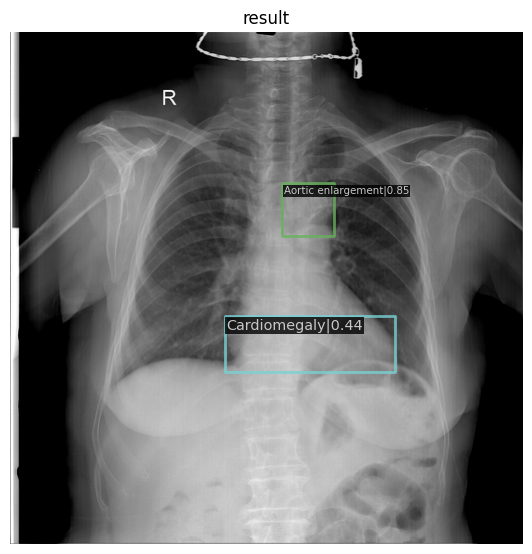

In [54]:
img = mmcv.imread(test_file[844])

model.cfg = cfg
predictions = inference_detector(model, img)
show_result_pyplot(model, img, predictions)


predictions의 길이는 4입니다. 이 4는 class의 개수를 의미하며
config에서 지정해준 순서대로, 즉 간단한 이름으로 01, 02, 04, 05를 나타냅니다.

따라서, 아래와 같은 경우 6개의 01 라벨과 5개의 05 라벨이 탐지되었다는 의미입니다.

하지만 위 사진을 보면 두 개만 시각화되었는데 11개의 탐지된 결과 중 기본 지정 threshold인 0.3을 넘는 데이터가 두 개 뿐이었기 때문입니다.

각 탐지된 결과는 5개의 element를 갖는데 앞의 4개가 bbox 좌표(x_min, y_min, x_max, y_max), 마지막 하나가 score(confidence)입니다.



In [55]:
len(predictions), predictions[0].shape, predictions[1].shape, predictions[2].shape, predictions[3].shape,predictions[4].shape

(14, (1, 5), (0, 5), (0, 5), (1, 5), (0, 5))

01 라벨의 스코어들을 보니 가장 첫 번째 탐지 결과만 살아남아 시각화된 걸 알 수 있습니다.

모든 테스트 데이터에 대해 추론을 진행합니다.

In [56]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))
        # labels scores box_xmin  box_xmax box_ymin box_ymax     
    return " ".join(pred_strings)

In [57]:
# Ref : https://www.kaggle.com/sreevishnudamodaran/siim-effnetv2-l-cascadercnn-mmdetection-infer?scriptVersionId=68887943&cellId=21


score_threshold = 0.5 # 0.8, 0.3, cfg.model.test_cfg.rcnn.score_thr
results = []


for index, img_path in tqdm(enumerate(test_file), total = len(test_file)):
    image_id = img_path.split("/")[-1].split(".")[0]
    file_name = img_path.split("/")[-1].split(".")[0]+".png"
    result = {
        'image_id': image_id,
        'PredictionString': '14 1.0 0 0 1 1'
    }

    img = mmcv.imread(img_path)
    predictions = inference_detector(model, img)
    boxes, scores, labels = (list(), list(), list())

    for k, cls_result in enumerate(predictions):
        # print("cls_result", cls_result)
        if cls_result.size != 0:
            if len(labels)==0:
                boxes = np.array(cls_result[:, :4])
                scores = np.array(cls_result[:, 4])
                labels = np.array([k+1]*len(cls_result[:, 4]))
            else:    
                boxes = np.concatenate((boxes, np.array(cls_result[:, :4])))
                scores = np.concatenate((scores, np.array(cls_result[:, 4])))
                labels = np.concatenate((labels, [k+1]*len(cls_result[:, 4])))

    if len(labels) != 0:
        # 라벨 -1 씩 SHIFT
        labels = labels - 1
        # no finding 이 -1에서 14로 이동!
        labels[labels == -1] = 14

        indexes = np.where(scores > score_threshold)
        # print(indexes)
        boxes = boxes[indexes]
        scores = scores[indexes]
        labels = labels[indexes]
        
        # 0.5 보다 confidence 높은 박스가 있다는 의미
        if len(boxes) > 0:
          result = {
              'image_id': image_id,
              'PredictionString': format_prediction_string(labels, boxes, scores)
          }
    # result list를 계속 append!
    results.append(result)


  0%|          | 0/3000 [00:00<?, ?it/s]

##Inference

In [58]:
import pandas as pd
submission = pd.DataFrame(results)
submission.shape

(3000, 2)

In [59]:
submission.head()

,image_id,PredictionString
0,ef7f329f4e29124e1d3bfec2b974f83c,0 0.9337 274.5097351074219 153.31338500976562 ...
1,ea1d58be10d8b14394ad4147c5fbb60e,0 0.9475 248.1182861328125 156.51490783691406 ...
2,9c84001b9cecc492efc1d459c8b18a85,14 1.0 0 0 1 1
3,b1191a037edd92e49073961f2762a013,0 0.9368 253.58934020996094 143.9445343017578 ...
4,163c884cba35d5d5ca50b7b8ea36a1fa,0 0.9207 264.97808837890625 127.40913391113281...


In [60]:
submission.to_csv('/home/ubuntu/mmdet512/output/mmdedtection_baseline.csv', index=False)